<a href="https://colab.research.google.com/github/arcrz28/Proyectos/blob/main/Proyecto_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **En este proyecto lo que hago o trato de hacer es una predicción sobre como ha cambiado el el precio de Petroleos Mexicanos (PEMEX) invertido en turbosina que es el combustible que usan los aviones. Todo eso a lo largo de varios años, en mi caso, tomo datos desde 2021-2024 y de esta manera saber o intentar realizar una predicción para un futuro y una comparación con años pasados**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# **En estra primera parte lo que haré es concatenar los archivos dado a que son  grandes, además de que de esta manera más adelante se podrá trabajar**

In [3]:
archivo1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diplomado/ARCHIVOS A USAR/Tarifas_TURBOSINA_26122023_02092024.csv', encoding='latin-1')
archivo2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diplomado/ARCHIVOS A USAR/TURBOSINADIC2021.csv', encoding='latin-1')

In [4]:
pd.concat([archivo1, archivo2]).to_csv('/content/drive/MyDrive/Colab Notebooks/Diplomado/ARCHIVOS A USAR/datos.csv', encoding='latin-1')

# **Aquí comenzamos con el código del proyecto, empezando por ver qué columnas tenemos y por limpiar datos**

In [5]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diplomado/ARCHIVOS A USAR/datos.csv', encoding='latin-1')
print(train_data.columns)

<ipython-input-5-ffec1582f651>:1: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diplomado/ARCHIVOS A USAR/datos.csv', encoding='latin-1')


Index(['Unnamed: 0', 'Vigencia_Inicio', 'Vigencia_Fin', 'Aeropuerto',
       'Nom_Aeropuerto', 'Gpo_Consumo', 'Tipo', 'Tarifa', 'No.', 'Descripcion',
       'Precio_Pemex', 'Descnto_Pemex', 'Almacenamiento_Origen',
       'Almacenamiento_Base', 'Almacenamiento_Hidrante',
       'Alm_Horario_Extraordinario', 'Expedio_Autotanque',
       'Expendio _ispensador', 'Exp_Horario_extraordinario', 'Tarifa_Succion',
       'COM_ALM_EXP_AUTOTANQUE', 'COM_ALM_EXP_HIDRANTE',
       'COM_ALM_EXP_AUTOTANQUE.1', 'COM_ALM_EXP_HIDRANTE.1',
       'ALM_EXP_AUTOTANQUE', 'ALM_EXP_HIDRANTE', 'ALM_EXP_AUTOTANQUE.1',
       'ALM_EXP_HIDRANTE.1'],
      dtype='object')


In [53]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diplomado/ARCHIVOS A USAR/datos.csv', parse_dates=True,  encoding='latin-1', index_col= 'Vigencia_Fin')
train_data_or = train_data[train_data['Descripcion'] == 'TURBOSINA'][['Precio_Pemex', 'Almacenamiento_Base', 'Tarifa_Succion', 'COM_ALM_EXP_AUTOTANQUE']]
# Limpieza de datos
for col in train_data_or.columns:
    train_data_or[col] = train_data_or[col].str.replace('$', '', regex=True).str.replace(' ', '', regex=True)  # COMO MI ARCHIVO TIENE SIMBOLOS DE PESOS '$', LOS REMUEVO,
    #AL IGUAL QUE LOS ESPACIOS Y LOS CONVIERTO TODOS YA EN VALORES NUMERICOS,
    #DADO A QUE EL CODIGO NO PUEDE TRABAJAR CON LO CONTRARIO
    train_data_or[col] = pd.to_numeric(train_data_or[col], errors='coerce')
train_data_or.replace(['---', '               ---', 'NaN', '', ' ', '-', '_', '$'], np.nan, inplace=True)

train_data_or.index = pd.to_datetime(train_data_or.index.astype(str), format='%d%m%Y')

imputer = SimpleImputer(strategy='mean')
train_data_or = pd.DataFrame(imputer.fit_transform(train_data_or), columns=train_data_or.columns, index=train_data_or.index)


<ipython-input-53-8b3f4b6d7ca4>:1: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diplomado/ARCHIVOS A USAR/datos.csv', parse_dates=True,  encoding='latin-1', index_col= 'Vigencia_Fin')
<ipython-input-53-8b3f4b6d7ca4>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diplomado/ARCHIVOS A USAR/datos.csv', parse_dates=True,  encoding='latin-1', index_col= 'Vigencia_Fin')


In [54]:
# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))    ###transforma los datos en ceros y uno
train_scaled = scaler.fit_transform(train_data_or)

# Crear secuencias de temporales, datos para el entrenamiento
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_scaled, 60)

# **LSTM se eligió porque es una estrategia para trabajar con datos de diferente longitud y aprender las dependencias a largo plazo. Además, pienso que este tipo de capa al "recordar" los datos, aprende mejor**

In [55]:
# Modelo LSTM
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),  #return_sequences=True Devuelve salidas para cada paso (necesario para apilar LSTM)
    Dropout(0.2), #evita el sobreajuste , apaga aleatoriamete el 20% de las neuronas durante el entrenamiento#
    LSTM(100, return_sequences=False), #return sequences = False nos da la salid final y no toda la secuencia
    Dense(1) #capa final densa
])
model.compile(optimizer=Adam(learning_rate=0.00025), loss='binary_crossentropy', metrics=['accuracy'], )

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,501 (478.52 KB)

 Trainable params: 122,501 (478.52 KB)

 Non-trainable params: 0 (0.00 B)

# **Decidí utilizar el optimizador Adam porque al ir usando "prueba y error" con otros optimizadores, hay una diferencia en la eficiencia de aprendizaje de mi red neuronal, además de que éste converge más rápido el descenso del gradiente y se puede ajustar la tasa de aprendizaje**

In [56]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=100, verbose=1)

Epoch 1/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 7.9223e-04 - loss: 0.7057
Epoch 2/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 8.6960e-04 - loss: 0.6854
Epoch 3/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 9.5507e-04 - loss: 0.6850
Epoch 4/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 6.9183e-04 - loss: 0.6850
Epoch 5/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.0011 - loss: 0.6847
Epoch 6/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 9.2052e-04 - loss: 0.6845
Epoch 7/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 7.9043e-04 - loss: 0.6842
Epoch 8/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 9.3130e-04 - loss: 0.6846
Epoch 9/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 9.6814e-04 - loss: 0.6841
Epoch 10/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 9.0485e-04 - loss: 0.6843
Epoch 11/50
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accu

In [58]:
# Preparar los datos reales de 2024 para comparación

real_data_2024 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diplomado/ARCHIVOS A USAR/Tarifas_TURBOSINA_26122023_02092024.csv', encoding='latin-1', parse_dates=True, index_col= 'Vigencia_Fin')
real_data_2024.index = pd.to_datetime(real_data_2024.index.astype(str), format='%d%m%Y') ###Esta parte la utilizo porque la columna de la fecha no contiene los
#carácteres tipo / o - para la fecha, es decir en lugar de 12-01-2024 solo es 12012024
real_data_2024 = real_data_2024[['Precio_Pemex', 'Almacenamiento_Base', 'Tarifa_Succion', 'COM_ALM_EXP_AUTOTANQUE']]
real_data_2024.replace(['---', '               ---', 'NaN', '', ' '], np.nan, inplace=True)
real_data_2024 = pd.DataFrame(imputer.transform(real_data_2024), columns=real_data_2024.columns, index=real_data_2024.index)
real_scaled = scaler.transform(real_data_2024)


<ipython-input-58-0d61e4bb974f>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  real_data_2024 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Diplomado/ARCHIVOS A USAR/Tarifas_TURBOSINA_26122023_02092024.csv', encoding='latin-1', parse_dates=True, index_col= 'Vigencia_Fin')
<ipython-input-58-0d61e4bb974f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_data_2024.replace(['---', '               ---', 'NaN', '', ' '], np.nan, inplace=True)


In [59]:
# Crear datos de entrada para predicción
X_real, _ = create_dataset(np.vstack([train_scaled[-60:], real_scaled]), 60)

# Predicciones
predictions_scaled = model.predict(X_real)
predictions = scaler.inverse_transform(np.concatenate([predictions_scaled, np.zeros((len(predictions_scaled), 3))], axis=1))[:, 0]

# Datos reales para comparar
real_demand = scaler.inverse_transform(real_scaled)[:, 0]

3753/3753 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


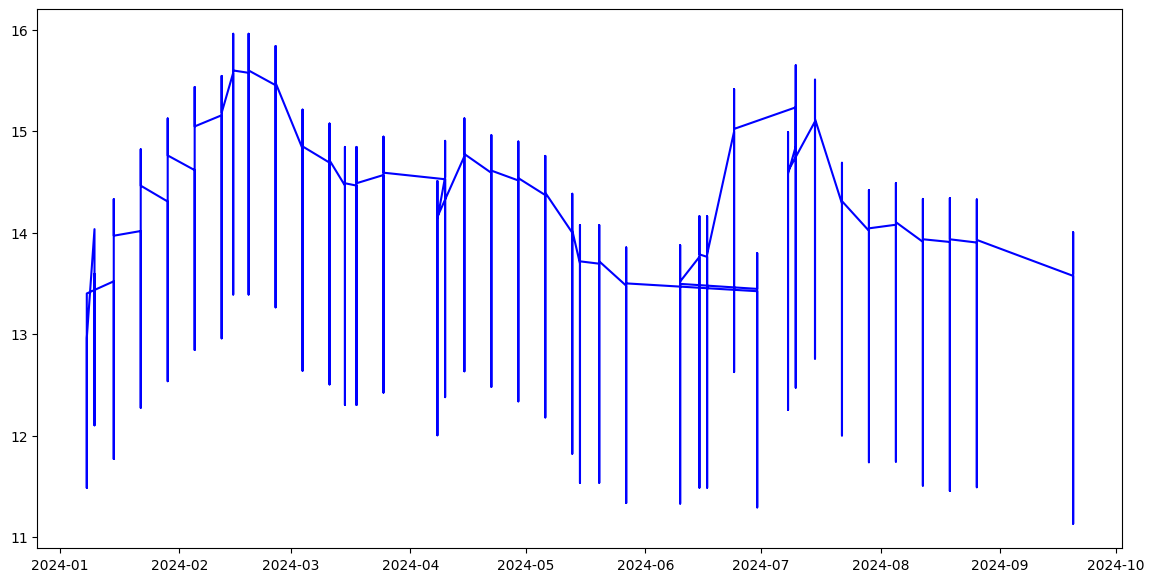

In [74]:

# Graficar
plt.figure(figsize=(14, 7))
plt.plot(real_demand,label='Datos reales', color='blue')

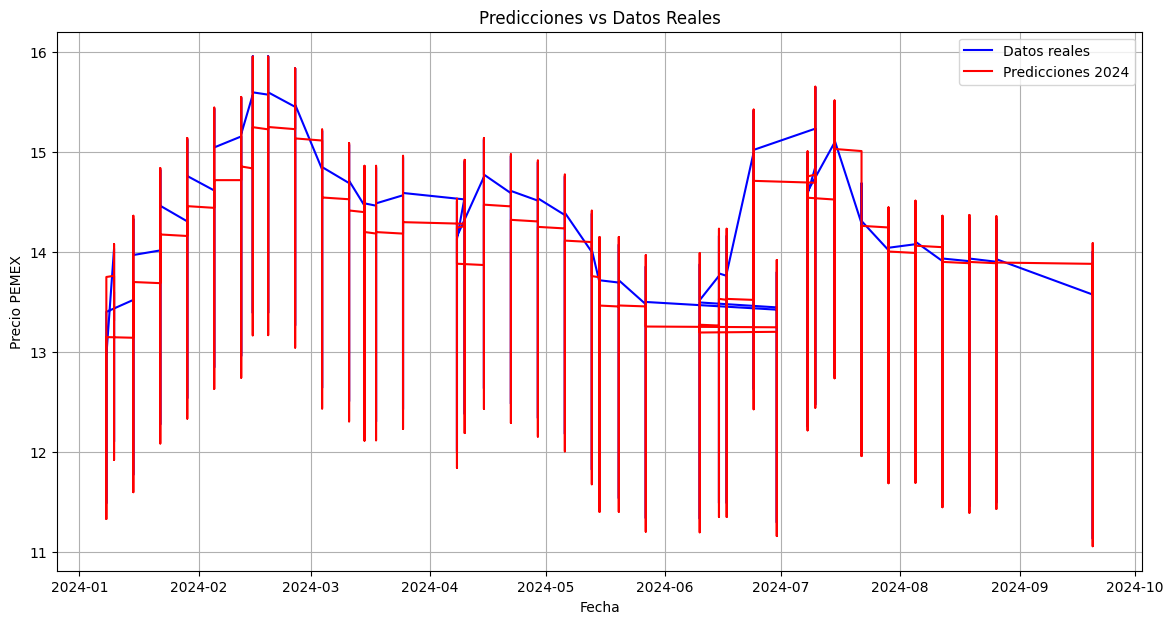

In [77]:

# Graficar
plt.figure(figsize=(14, 7))
plt.plot(real_data_2024.index, real_demand, label='Datos reales', color='blue')
plt.plot(real_data_2024.index[:len(predictions)], predictions, label='Predicciones 2024', color='red')
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Precio PEMEX')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
import plotly.graph_objects as go
import pandas as pd
from sklearn.metrics import r2_score

# Asegurarse de que tanto 'real_demand' como 'predictions' tienen el mismo índice de tiempo
real_demand = pd.Series(real_demand[:len(predictions)], index=real_data_2024.index[:len(predictions)])
predictions_series = pd.Series(predictions, index=real_data_2024.index[:len(predictions)])

# Crear una lista para almacenar los R-squared de cada mes
r_squared_monthly = []

# Agrupar los datos por mes y calcular el R-squared para cada mes
for month, group in real_demand.groupby(real_demand.index.month):
    # Extraer las predicciones correspondientes para ese mes
    pred_for_month = predictions_series[group.index]


if len(pred_for_month) > len(group):
    pred_for_month = pred_for_month[:len(group)]  # Tomar solo los primeros n elementos
elif len(group) > len(pred_for_month):
    group = group[:len(pred_for_month)]


    # Calcular el R-squared
    r_squared = r2_score(group, pred_for_month)

    # Almacenar el resultado
    r_squared_monthly.append((month, r_squared))
    print(f'R-squared para el mes {month}: {r_squared}')

# Crear la figura usando Plotly para una mejor interactividad y presentación
fig = go.Figure()

# Añadir los datos reales a la gráfica
fig.add_trace(go.Scatter(x=real_data_2024.index, y=real_demand, mode='lines', name='Datos Reales 2024', line=dict(color='blue')))

# Añadir las predicciones a la gráfica
fig.add_trace(go.Scatter(x=real_data_2024.index[:len(predictions)], y=predictions, mode='lines', name='Predicciones 2024', line=dict(color='red')))

# Configuración adicional del gráfico
fig.update_layout(
    title='Comparación de Predicciones vs Datos Reales 2024',
    xaxis_title='Fecha',
    yaxis_title='Precio PEMEX',
    legend_title='Leyenda'
)

# Mostrar la gráfica
fig.show()

# Imprimir los R-squared mensuales
for month, r_squared in r_squared_monthly:
    print(f"R-squared para el mes {month}: {r_squared:.4f}")